# Import required libraries

In [94]:
import warnings
warnings.filterwarnings('ignore')  #general warning suppression

import sys
import numpy as np
import json

import cv2
from skimage.io import imread
from skimage.draw import polygon

import tensorflow as tf
import keras.backend as K
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  #tensorflow deprecration warning suppression

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# Clone the Mask-RCNN repositroy

In [8]:
if not os.path.exists("Mask_RCNN"):
    !git clone https://github.com/matterport/Mask_RCNN.git
    print("Cloned repository")
else:
    print("Mask_RCNN directory already exists")

Mask_RCNN directory already exists


# Import Mask-RCNN library

In [9]:
#Required to import downloaded Mask_RCNN by below cells. Not needed if installed the repository by pip etc
sys.path.append("Mask_RCNN") 

from mrcnn.visualize import display_images
from mrcnn.model import log
import mrcnn.model as modellib
from mrcnn.config import Config
from mrcnn import utils, visualize

# Configuration for Mask-RCNN 

## Config 

In [55]:
class InferenceConfig(Config):
    NAME = "seed"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1  # background + 1 seeds
    IMAGE_MIN_DIM = 768
    IMAGE_MAX_DIM = 8192
    DETECTION_MAX_INSTANCES = 1000
    IMAGE_RESIZE_MODE = "pad64"
    RPN_NMS_THRESHOLD = 0.4
    DETECTION_MIN_CONFIDENCE = 0

config = InferenceConfig()

## Define Dataset Class

In [56]:
class CropSeedsDataset(utils.Dataset):

    def load_seeds(self, dataset_dir, input_folder="image", mask_folder="mask"):

        self.add_class("seed", 1, "seed")
        self.dataset_dir = dataset_dir
        self.mask_folder = mask_folder
        files = sorted([x for x in os.listdir(os.path.join(
            dataset_dir, input_folder)) if x.endswith(".png")])

        for file in files:
            self.add_image(
                "seed",
                image_id=file,
                path=os.path.join(dataset_dir, input_folder, file)
            )

    def load_mask(self, image_id):

        cm = plt.get_cmap("jet")
        colors = []
        for i in range(256):
            colors.append(cm(i)[:3])
        colors = (np.array(colors)*255).astype(np.int)
        colors = np.unique(colors, axis=1)

        info = self.image_info[image_id]["id"]
        image = imread(os.path.join(
            self.dataset_dir, self.mask_folder, info))
        mask = []
        for color in colors:
            m = cv2.inRange(image, color, color)
            # if there is a mask, average is not 0
            if np.average(m.flatten()) != 0:
                mask.append(m)
        mask = np.stack(mask, axis=-1)
        return mask, np.ones([mask.shape[-1]], dtype=np.int32)

# Load the model with trained weights

In [51]:
K.clear_session()
model = modellib.MaskRCNN(mode="inference", config=config, model_dir=".")
model.load_weights(
    "data/model_weights/mask_rcnn_barleyseeds_0040.h5", by_name=True)
print("model weights loaded")

model weights loaded


# Synthetic dataset

In [57]:
syn_dataset = CropSeedsDataset()
syn_dataset.load_seeds("data/synthetic_test/")
syn_dataset.prepare()

print("Image Count: {}".format(len(syn_dataset.image_ids)))
print("Class Count: {}".format(syn_dataset.num_classes))
for i, info in enumerate(syn_dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 200
Class Count: 2
  0. BG                                                
  1. seed                                              


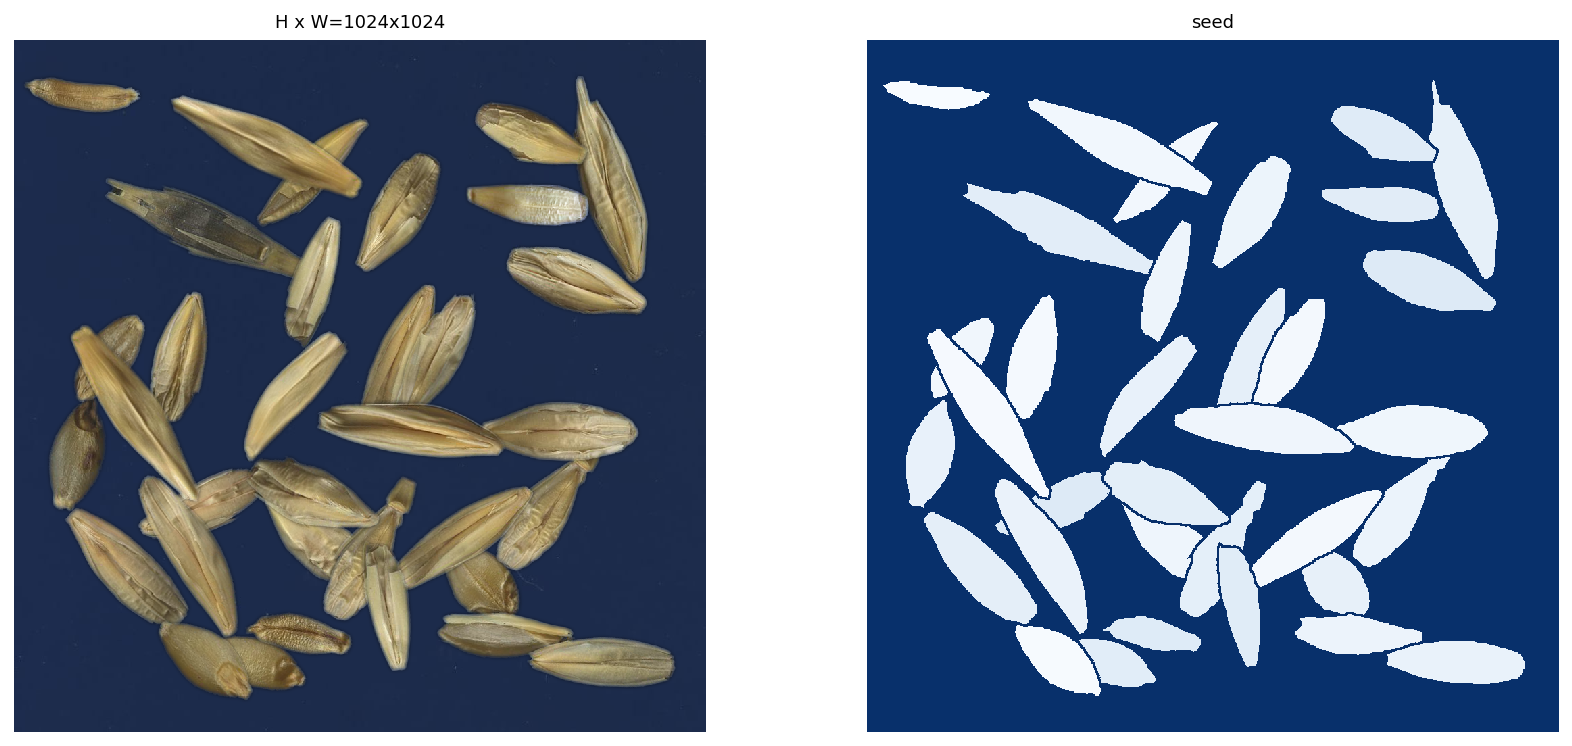

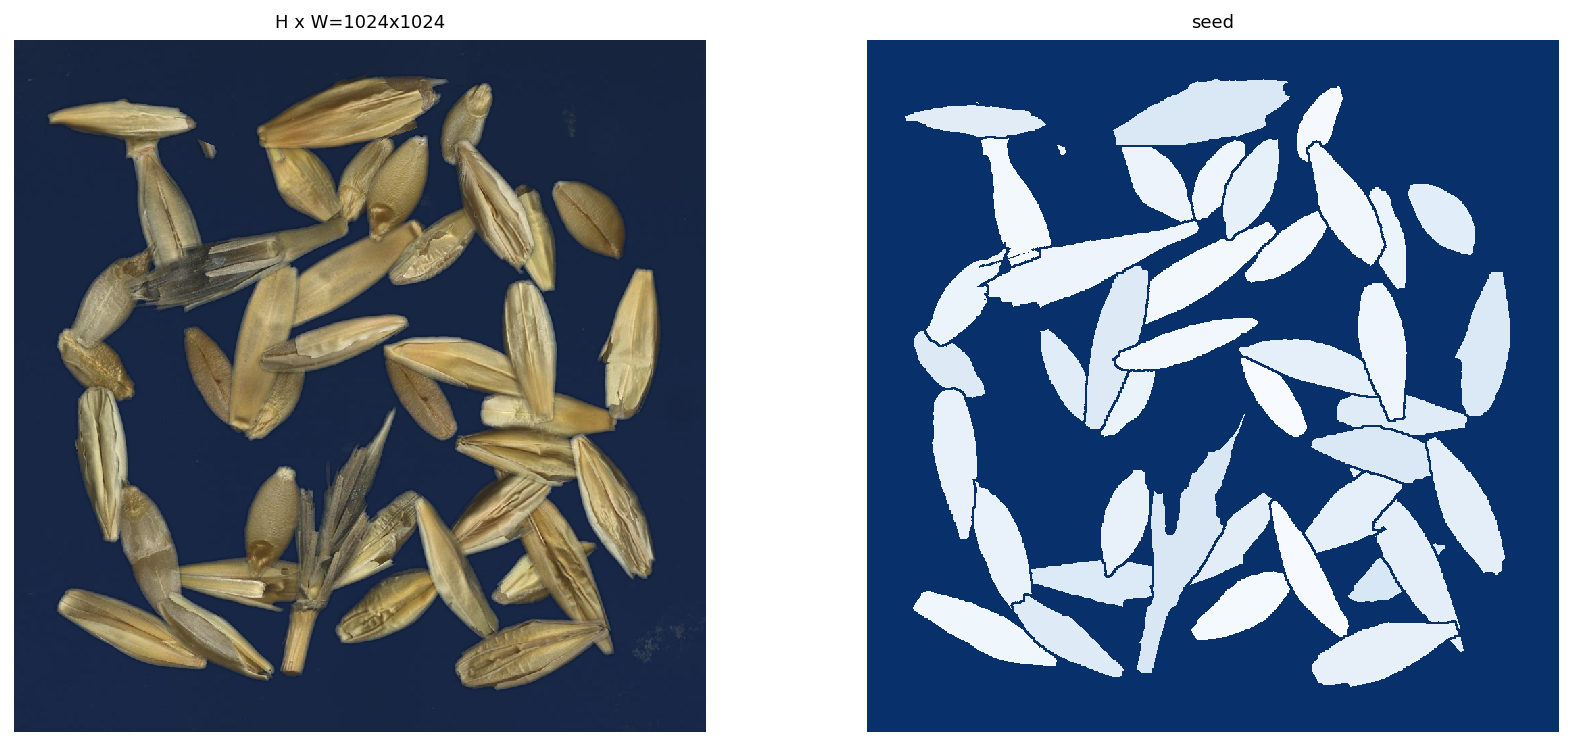

In [53]:
#select two random images from the dataset
image_ids = np.random.choice(syn_dataset.image_ids, 2)
for image_id in image_ids:
    image = syn_dataset.load_image(image_id)
    mask, class_ids = syn_dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, syn_dataset.class_names, limit=1)

## Inference and Evaluation

- select two random images from the dataset
- infer and display the result
- calculate  bbox recall iou 50
- calcculate mask AP iou 50

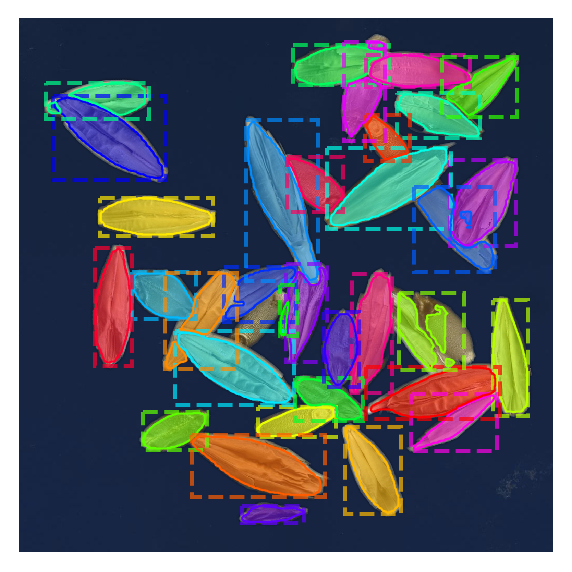

image: 105
bbox iou: 0.9428571428571428
mask AP50: 0.9142857193946838


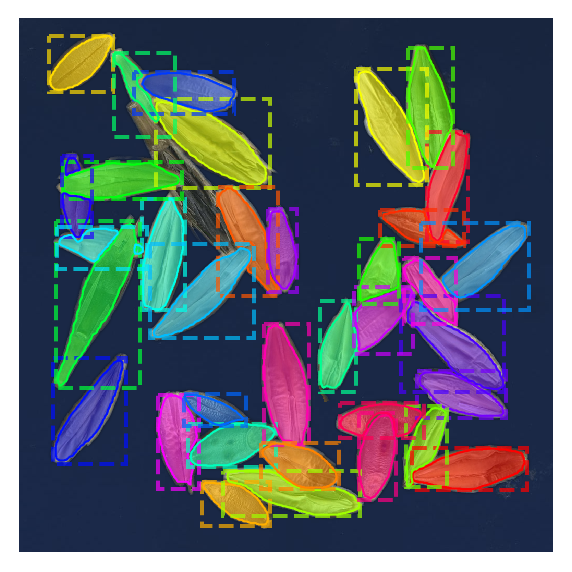

image: 139
bbox iou: 0.9722222222222222
mask AP50: 0.9722222089767456


In [62]:
iou = 0.5
image_ids = np.random.choice(syn_dataset.image_ids, 2)

for image_id in image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(syn_dataset, config, image_id)
    r = model.detect([image])[0]
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], ["",""],figsize=(5,5))
    
    recall = utils.compute_recall(r["rois"],gt_bbox,iou)[0]
    AP, _,_,_ = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                      r['rois'], r['class_ids'], r['scores'], r['masks'],iou_threshold = iou)
    
    print("image:",image_id)
    print("bbox iou:", recall)
    print("mask AP50:", AP)

# Real world dataset

Note: Different to the synthetic images, the labels are in format of json file.

In [78]:
real_world_dir = "./data/realworld_test/image"
json_dir = "./data/realworld_test/metadata.json"

In [79]:
with open(json_dir) as f:
    jsondata = json.load(f)
files = [x["External ID"] for x in jsondata]
print(files)

['B669.jpg', 'C656.jpg', 'H602.jpg', 'I622.jpg', 'J247.jpg', 'K735.jpg', 'U051.jpg', 'C319.jpg', 'E245.jpg', 'I304.jpg', 'I626.jpg', 'J647.jpg', 'N009.jpg', 'U353.jpg', 'C346.jpg', 'E612.jpg', 'I335.jpg', 'J064.jpg', 'K692.jpg', 'T567.jpg']


In [97]:
def get_gt_mask(image,jsondata,n):
    shape = (image.shape[0],image.shape[1],len(jsondata[n]["Label"]["seed_mask"]))
    gt_mask = np.full(shape,False,dtype=bool)
    for i in range(len(jsondata[n]["Label"]["seed_mask"])):
        _x = []
        _y = []
        for coord in jsondata[n]["Label"]["seed_mask"][i]["geometry"]:
            _x.append(coord["x"])
            _y.append(coord["y"])
        rr,cc = polygon(_y,_x)
        _mask = np.zeros((image.shape[0],image.shape[1]),dtype=np.uint8)
        _mask[rr,cc] = True
        gt_mask[...,i] = _mask
    gt_mask = np.array(gt_mask)
    return gt_mask

def get_gt_bbox(image,jsondata,n):
    gt_bbox = []
    for i in range(len(jsondata[n]["Label"]["seed_bbox"])):

        #1. sanitize the coordinate so that it fits the image size range
        #2. the order of the coordinate is ambiguous, so calculating to get the top left and bottom right
        a = jsondata[n]["Label"]["seed_bbox"][i]["geometry"]

        #1. check
        for i,coord in enumerate(a):
            if coord["x"]<1: a[i]["x"]=1
            if coord["x"]>=image.shape[1]: a[i]["x"]=image.shape[1] -1
            if coord["y"]<1: a[i]["y"]=1   
            if coord["y"]>=image.shape[0]: a[i]["y"]=image.shape[0] -1

        #2. get top left and bottom right
        coords = [np.array([q["y"],q["x"]]) for q in a]
        tlidx = np.argmin([np.linalg.norm(coord - np.array([0,0])) for coord in coords])
        bridx = np.argmax([np.linalg.norm(coord - np.array([0,0])) for coord in coords])

        _c = list(coords[tlidx]) + list(coords[bridx])
        gt_bbox.append(_c)
    gt_bbox = np.array(gt_bbox)
    return gt_bbox

will visualize these files:  ['C346.jpg' 'J247.jpg']
image: C346.jpg
bbox recall: 0.9811320754716981
mask AP50: 0.9719676898131893


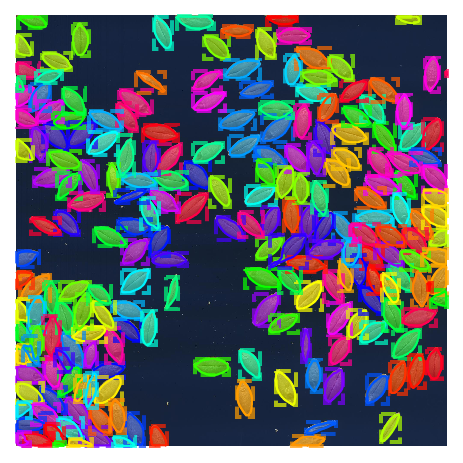

image: J247.jpg
bbox recall: 0.9421487603305785
mask AP50: 0.9668020560579785


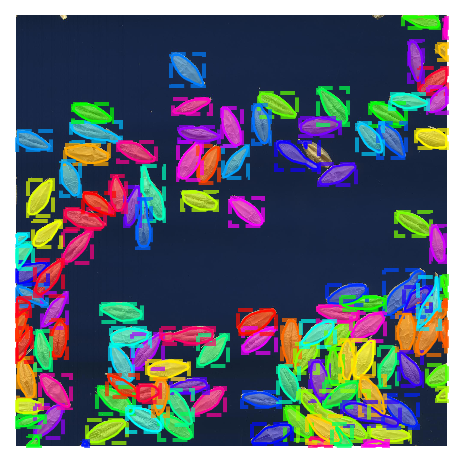

In [121]:
iou = 0.5
selected_files = np.random.choice(files,2)
print("will visualize these files: ", selected_files)

for file in selected_files:
    image = imread(os.path.join(real_world_dir,file))    
    r = model.detect([image],verbose=0)[0]
    
    #get the position within the jsondata
    for i,a in enumerate(jsondata):
        if file == a["External ID"]:
            n = i
    
    gt_mask = get_gt_mask(image,jsondata,n)
    gt_bbox = get_gt_bbox(image,jsondata,n)
    gt_class_id = np.array([1] * len(gt_bbox))
    
    
    recall = utils.compute_recall(r["rois"],gt_bbox,iou)[0]
    AP, _,_,_ = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                      r['rois'], r['class_ids'], r['scores'], r['masks'],iou_threshold = iou)
    
    print("image:",file)
    print("bbox recall:", recall)
    print("mask AP50:", AP)

    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], ["",""],figsize=(4,4))